In [ ]:
import os
import torch
import logging
import torch.nn as nn
import torchvision.models as models

from tqdm import tqdm
from pathlib import Path
from PIL import Image
from torchvision.transforms import v2, InterpolationMode
from torch.utils.data import Dataset, DataLoader



# Utils

In [2]:
def confusion_counts(y_true, y_pred):
    """
    Computes raw TP, FP, TN, FN for binary classification
    """
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()

    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    TN = ((y_pred == 0) & (y_true == 0)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    FN = ((y_pred == 0) & (y_true == 1)).sum().item()

    return TP, FP, TN, FN

In [ ]:
# model evaluation
def test_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test dataset.

    Parameters:
    - model (nn.Module): The trained model to evaluate.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
    - device (torch.device): The device to run on (e.g., 'cuda' or 'cpu').
    """
    
    # Set the model to evaluation mode (e.g., turns off dropout)
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    all_preds = []
    all_labels = []

    # Disable gradient calculations
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to the specified device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            
            # Calculate the loss
            loss = criterion(outputs, y_batch)
            
            # Accumulate the loss
            test_loss += loss.item() * X_batch.size(0)
            
            # Get the predictions
            _, preds = torch.max(outputs, 1)
            
            # Accumulate correct predictions and total count
            test_correct += (preds == y_batch).sum().item()
            test_total += y_batch.size(0)
            
            # Store all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate final metrics
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    
    # --- Calculate TP, FP, TN, FN for binary classification ---
    # Assumes class 1 is the "positive" class
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(all_preds)):
        pred = all_preds[i]
        label = all_labels[i]
        
        if pred == 1 and label == 1:
            TP += 1
        elif pred == 1 and label == 0:
            FP += 1
        elif pred == 0 and label == 0:
            TN += 1
        elif pred == 0 and label == 1:
            FN += 1

    # Calculate Precision, Recall, and F1-score
    # Add a small epsilon (1e-6) to avoid division by zero
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # Print the results
    print("\n--- Test Results ---")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_correct}/{test_total})")
    print("---")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    print("---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print("--------------------\n")

    return avg_test_loss, test_accuracy, precision, recall, f1_score

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [5]:
dataset_path = os.path.join(os.getcwd(), "..", "..", "dataset")
sample_dataset = os.path.join(dataset_path, "sample.csv")
raw_subset_dataset = os.path.join(dataset_path, 'corn-leaf-disease-subset-raw')
subset_dataset = os.path.join(dataset_path, 'corn-leaf-disease-subset')

# raw_train_dir = os.path.join(raw_subset_dataset, 'train')
# raw_valid_dir = os.path.join(raw_subset_dataset, 'valid')
# raw_test_dir = os.path.join(raw_subset_dataset, 'test')

subset_train_dir = os.path.join(subset_dataset, 'train')
subset_valid_dir = os.path.join(subset_dataset, 'valid')
subset_test_dir = os.path.join(subset_dataset, 'test')

In [6]:
class CornLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        # Get all image paths and corresponding labels
        exts = ('.jpg', '.jpeg', '.png')
        self.image_paths = []
        self.labels = []
        
        # Map class names to integer labels
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        
        for cls_name in self.class_names:
            cls_folder = self.root_dir / cls_name
            files = list(cls_folder.glob('*'))
            for f in files:
                if f.suffix.lower() in exts:
                    self.image_paths.append(f)
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
preprocess_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    
    v2.Resize(size=(224,224),
              interpolation=InterpolationMode.BILINEAR),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [40]:
train_dataset = CornLeafDataset(subset_train_dir, transform=preprocess_transforms)
valid_dataset = CornLeafDataset(subset_valid_dir, transform=preprocess_transforms)
test_dataset  = CornLeafDataset(subset_test_dir, transform=preprocess_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

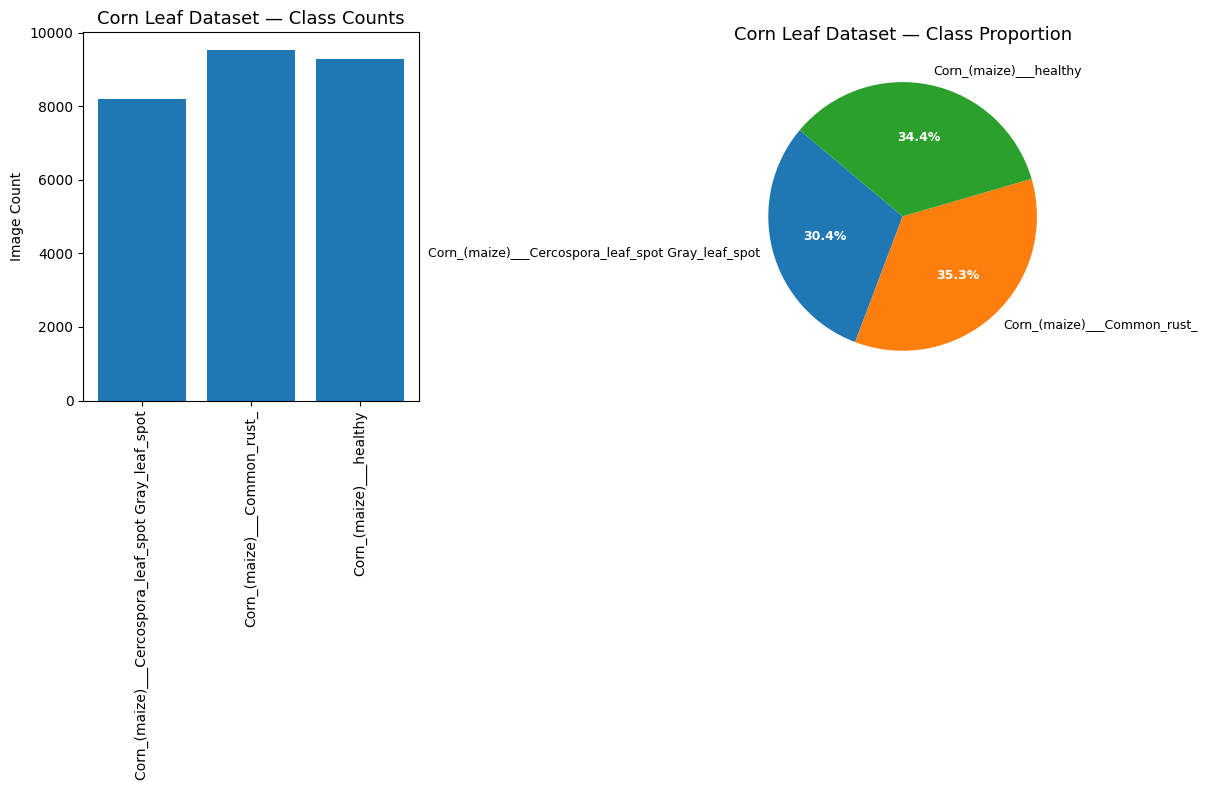

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# --- Compute distribution ---
label_counts = Counter(train_dataset.labels)
class_distribution = {
    train_dataset.idx_to_class[idx]: count
    for idx, count in sorted(label_counts.items())
}

labels = list(class_distribution.keys())
counts = list(class_distribution.values())

# --- Plot histogram and pie chart side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Histogram (bar chart)
axes[0].bar(labels, counts)
axes[0].set_title("Corn Leaf Dataset — Class Counts", fontsize=13)
axes[0].set_ylabel("Image Count")
axes[0].tick_params(axis='x', rotation=90)

# Pie chart
wedges, texts, autotexts = axes[1].pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 9}
)
plt.setp(autotexts, size=9, weight="bold", color="white")
axes[1].set_title("Corn Leaf Dataset — Class Proportion", fontsize=13)

plt.tight_layout()
plt.show()

In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [12]:
model.fc = nn.Linear(2048, 3)
model.fc

Linear(in_features=2048, out_features=3, bias=True)

In [13]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Hyper Parameter
num_classes = 2
learning_rate = 1e-2
weight_decay = 5e-3
momentum = 0.9

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=5e-3, momentum=0.9)

In [ ]:
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

In [16]:
# Train
num_epochs = 10
min_train_loss = 10000
min_val_loss = 10000

TP_list, FP_list, TN_list, FN_list = [], [], [], []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in tqdm(range(num_epochs)):
    # ---- TRAIN ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    train_pbar = tqdm(train_loader, desc=f"Training [{epoch+1}/{num_epochs}]", leave=False)
    
    for X_batch, y_batch in train_pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    epoch_TP, epoch_FP, epoch_TN, epoch_FN = 0, 0, 0, 0
    
    val_pbar = tqdm(valid_loader, desc=f"Validating [{epoch+1}/{num_epochs}]", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in val_pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
            
            tp, fp, tn, fn = confusion_counts(y_batch, preds)
            
            epoch_TP += tp
            epoch_FP += fp
            epoch_TN += tn
            epoch_FN += fn
            
    val_acc = val_correct / val_total
    val_loss /= val_total

    TP_list.append(epoch_TP)
    FP_list.append(epoch_FP)
    TN_list.append(epoch_TN)
    FN_list.append(epoch_FN)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    # save model
    if min_val_loss > val_loss:
        torch.save(model.state_dict(), f'./model/best-resnet50-corn-disease.pth')
        min_val_loss = val_loss
        print(f"Saved new best model (val_loss: {val_loss:.4f})")
    else:
        torch.save(model.state_dict(), f'./model/last-resnet50-corn-disease.pth')
        

 10%|█         | 1/10 [02:43<24:34, 163.82s/it]

Epoch [1/10] Train Loss: 0.0839, Acc: 0.9838 | Val Loss: 0.0387, Acc: 0.9939
Saved new best model (val_loss: 0.0387)


 20%|██        | 2/10 [05:32<22:12, 166.59s/it]

Epoch [2/10] Train Loss: 0.0419, Acc: 0.9938 | Val Loss: 0.0352, Acc: 0.9942
Saved new best model (val_loss: 0.0352)


 30%|███       | 3/10 [08:18<19:26, 166.61s/it]

Epoch [3/10] Train Loss: 0.0379, Acc: 0.9947 | Val Loss: 0.0328, Acc: 0.9948
Saved new best model (val_loss: 0.0328)


 40%|████      | 4/10 [11:09<16:49, 168.21s/it]

Epoch [4/10] Train Loss: 0.0389, Acc: 0.9944 | Val Loss: 0.0322, Acc: 0.9948
Saved new best model (val_loss: 0.0322)


 50%|█████     | 5/10 [14:02<14:08, 169.80s/it]

Epoch [5/10] Train Loss: 0.0381, Acc: 0.9947 | Val Loss: 0.0335, Acc: 0.9947


 60%|██████    | 6/10 [16:46<11:11, 167.97s/it]

Epoch [6/10] Train Loss: 0.0385, Acc: 0.9947 | Val Loss: 0.0334, Acc: 0.9945


 70%|███████   | 7/10 [19:28<08:17, 165.89s/it]

Epoch [7/10] Train Loss: 0.0376, Acc: 0.9950 | Val Loss: 0.0341, Acc: 0.9945


 80%|████████  | 8/10 [22:28<05:40, 170.32s/it]

Epoch [8/10] Train Loss: 0.0391, Acc: 0.9941 | Val Loss: 0.0332, Acc: 0.9948


 90%|█████████ | 9/10 [25:14<02:49, 169.11s/it]

Epoch [9/10] Train Loss: 0.0369, Acc: 0.9950 | Val Loss: 0.0332, Acc: 0.9947


100%|██████████| 10/10 [27:58<00:00, 167.87s/it]

Epoch [10/10] Train Loss: 0.0368, Acc: 0.9952 | Val Loss: 0.0329, Acc: 0.9945


In [19]:
num_classes = 3 

best_model = models.resnet50(weights=None)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load('./model/best-resnet50-corn-disease.pth'))
best_model.to(device=device)

best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

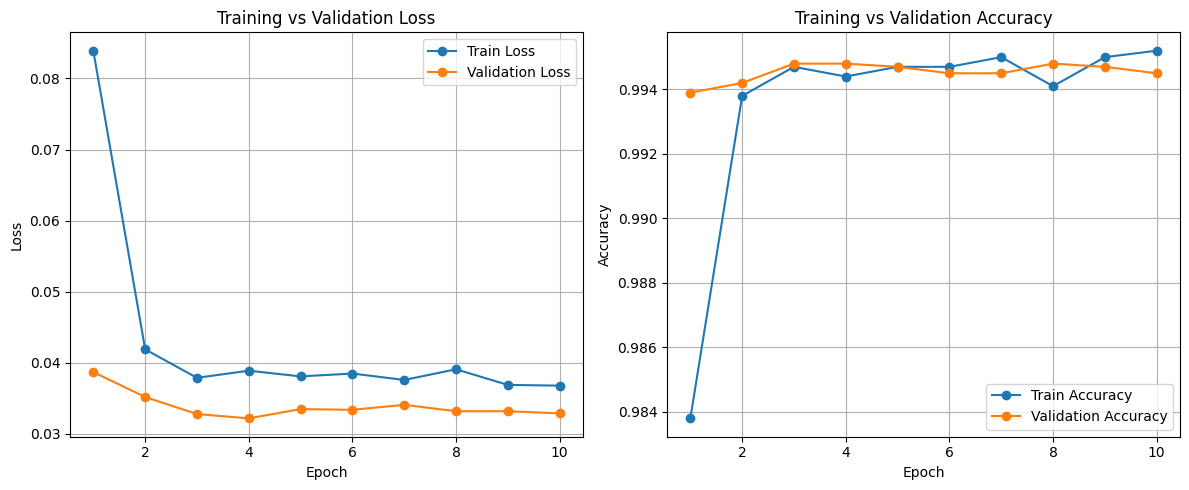

In [38]:
train_loss = [0.0839, 0.0419, 0.0379, 0.0389, 0.0381, 0.0385, 0.0376, 0.0391, 0.0369, 0.0368]
train_acc = [0.9838, 0.9938, 0.9947, 0.9944, 0.9947, 0.9947, 0.9950, 0.9941, 0.9950, 0.9952]
val_loss = [0.0387, 0.0352, 0.0328, 0.0322, 0.0335, 0.0334, 0.0341, 0.0332, 0.0332, 0.0329]
val_acc = [0.9939, 0.9942, 0.9948, 0.9948, 0.9947, 0.9945, 0.9945, 0.9948, 0.9947, 0.9945]
epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(12, 5))

# ---- LOSS CURVE ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ---- ACCURACY CURVE ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
avg_test_loss, test_accuracy, precision, recall, f1_score=test_model(best_model, test_loader, criterion, device)


--- Test Results ---
Test Loss: 0.0355
Test Accuracy: 0.9933 (1343/1352)
---
True Positives (TP): 473
False Positives (FP): 1
True Negatives (TN): 409
False Negatives (FN): 3
---
Precision: 0.9979
Recall: 0.9937
F1-Score: 0.9958
--------------------



In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

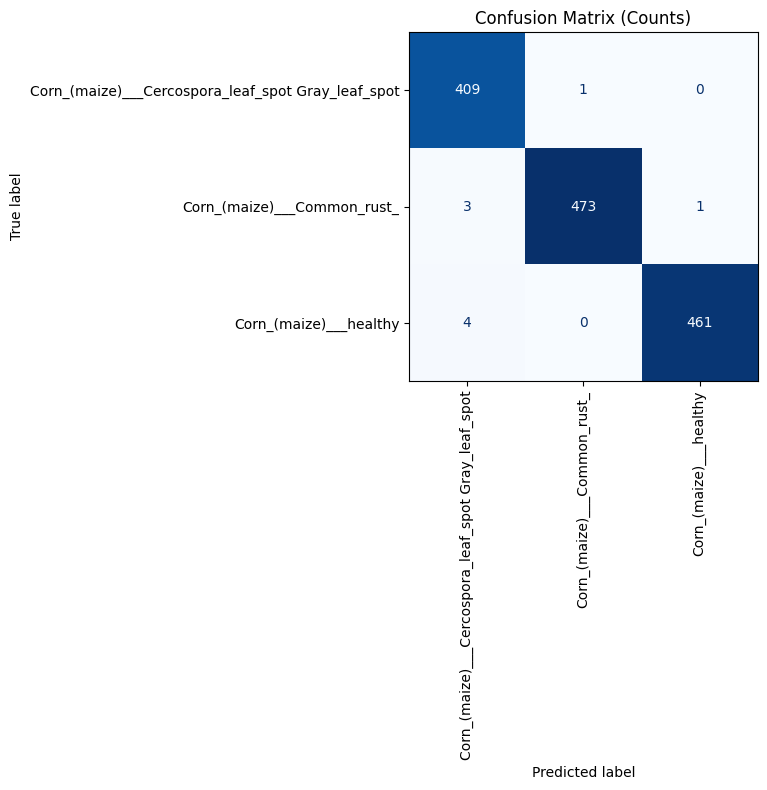

In [43]:
cm = confusion_matrix(all_labels, all_preds)

class_names = list(train_dataset.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', colorbar=False)

plt.setp(ax.get_xticklabels(), 
         rotation=90,
         ha='right',
         va='center',
         rotation_mode='anchor')

ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()